# Sentiment Analysis of Tweets about Covid-19 Vaccine

### Creating and cleaning data set

#### A. Importing necessary libaries and using Twitter API

In [2]:
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

#Variables that contain user credentials to access Twitter API
consumer_key = "yYpev4mkHDBgkZUyNnO4WVgZu"
consumer_key_secret = "au0iwqbzzcx0X3tTBv9tNjDrlS0YEKBerBNqsdESWjXYVhqQea"
bearer_token = "AAAAAAAAAAAAAAAAAAAAACibKwEAAAAAdvvAjwZWgizutr3JFBF6OclQ%2FBY%3DpU2UBFn5i4PBuT1CXGzbjJZQo8c14TnBAWV60mA82kYaDjDryP"
access_token = "613117213-4cTYltkcdzKXK043NytsbKSZCzV8kc63lA8cBXPY"
access_token_secret = "vFYAUrxm3r9fZ9anGI5aA9lzmrw2pzzKpcSoxmfjMcJt2"

In [3]:
#obtaining tweets using API
search_words = "#CovidVaccine" + " -filter:retweets"
date_since = "2020-12-15"
auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

tweets = tweepy.Cursor(api.search,
              q=search_words,
              lang="en",
              since=date_since).items(1500)

In [4]:
all_tweets = [tweet.text for tweet in tweets]
#print(len(all_tweets))

#### B. Creating data frame of tweets and cleaning tweets

In [5]:
df = pd.DataFrame(all_tweets, columns = ['Tweets'])
df.head()

,Tweets
0,It s called the #britishvirus #COVID19 #CovidV...
1,1.80 lakh Covishield vaccine reaches Kochi; to...
2,CCAMP startup @Blackfroghealth talks to @ndtv ...
3,Another reaction 😡😡😡\n#CovidVaccine \n#CovidVa...
4,@kgotsoolebogeng @TheReal_Mlu_ @phakxx You are...


In [6]:
#function to clean the text, remove extraneous information
def cleanText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text) #remove hyperlink
    return text

df['Tweets'] = df['Tweets'].apply(cleanText)

### Begin Sentiment Analysis! Add subjectivity, polarity, and overall analysis of tweets to dataframe

In [7]:
#function to get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#get polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#create columns in df
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

In [8]:
#function to obtain general sentiment
def getAnalysis(score):
    if score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    else:
        return "Positive"

df['Analysis'] = df['Polarity'].apply(getAnalysis)

#### Visualizations of overall tweet sentiments

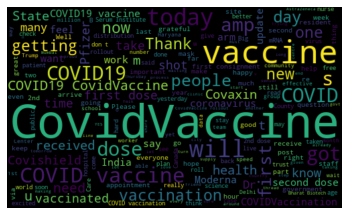

In [9]:
#Word Cloud
allWords = ' '.join([twts for twts in df['Tweets']])
wordCloud = WordCloud(width=500,height=300,random_state=21,max_font_size=110).generate(allWords)
plt.imshow(wordCloud,interpolation='bilinear')
plt.axis('off')
plt.show()

Based on the word cloud created from the 1500 tweets gathered, it appears that many of the popular words in these tweets are generally neutral or positive. Disregarding the different variations of "Covid Vaccine" shown, taking a closer look at the word cloud shows words like "thank", "grateful", "good", "happy", "trust", and "effective." It seems that discourse about the vaccine based on the tweets are generally positive. People are happy and trusting of the vaccine coming out. The word cloud did not show many words that are explicitly negative. In addition, the word cloud can provide valuable insight into the types of discussions that are being had. Words such as "second dose", "first dose", "distribution", "rollout", and "school" show up, which may indicate that people are discussing their experiences with getting various dosages, and talking about the methods in which the vaccine is being distributed, as well as how this might impact structures such as schools. Based on this word cloud, these are the issues that are particularly important/salient to the public (on Twitter at least).

Text(0, 0.5, 'Subjectivity')

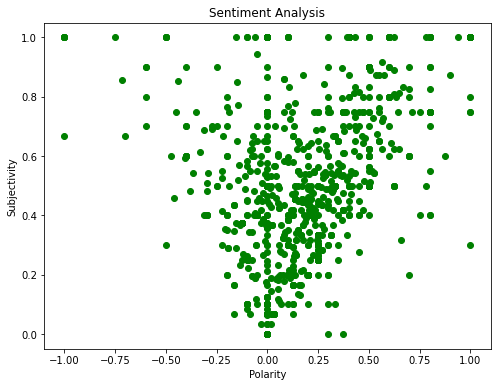

In [10]:
#plot polarity and subjectivity
plt.figure(figsize = (8,6))
for i in range(0,df.shape[0]):
    plt.scatter(df['Polarity'][i], df['Subjectivity'][i], color = "Green")
    
plt.title("Sentiment Analysis")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")

Similar to the word cloud, this scatterplot of subjectivity and polarity of tweets shows us that, while there is a wide spread of the sentiment of the tweets, more tweets fall in the neutral or positive end of the spectrum than the negative end. Discourse on the COVID Vaccine is largely supportive. The spread of subjectivity is also very wide, but it seems that few of the tweets are entirely subjective. The bar plot below is also another visualization of this trend.

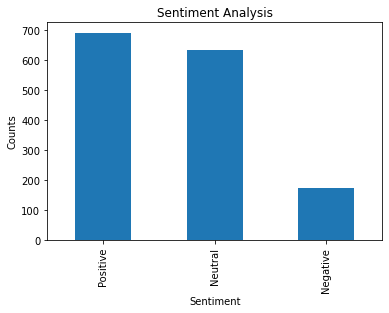

In [11]:
df['Analysis'].value_counts()

#plot counts
plt.title('Sentiment Analysis')
plt.xlabel("Sentiment")
plt.ylabel("Counts")
df['Analysis'].value_counts().plot(kind='bar')
plt.show()

In [12]:
#create CSV file for viewing
df.to_csv("covidtweets.csv", sep = ',')

### Begin Sentiment Analysis using Naive Bayes Classifier

In [14]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tiffanyzheng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
#get percentage of positive tweets
ptweets = df[df.Analysis == "Positive"]
ptweets = ptweets["Tweets"]

features_positive = [(f, 
           'Positive') for f in ptweets]

#get percentage of negative tweets
ntweets = df[df.Analysis == "Negative"]
ntweets = ntweets["Tweets"]
features_negative = [(f, 
           'Negative') for f in ntweets]

In [16]:
# Split the data into train and test (80/20)
threshold_factor = 0.8
threshold_pos = int(threshold_factor * len(features_positive))
threshold_neg = int(threshold_factor * len(features_negative))

In [17]:
#create training set and testing set
features_train = features_positive[:threshold_pos] + features_negative[:threshold_neg]
features_test = features_positive[threshold_pos:] + features_negative[threshold_neg:]  
print("\nNumber of training datapoints:", len(features_train))
print("Number of test datapoints:", len(features_test))


Number of training datapoints: 691
Number of test datapoints: 174


In [18]:
all_words = set(word.lower() for passage in features_train for word in word_tokenize(passage[0]))
t = [({word: (word in word_tokenize(x[0])) for word in all_words}, x[1]) for x in features_train]

In [19]:
test_words = set(word.lower() for passage in features_test for word in word_tokenize(passage[0]))
t1 = [({word: (word in word_tokenize(x[0])) for word in all_words}, x[1]) for x in features_test]

In [20]:
# Train a Naive Bayes classifier
classifier = NaiveBayesClassifier.train(t)
print("\nAccuracy of the classifier:", nltk.classify.util.accuracy(classifier, t1))


Accuracy of the classifier: 0.7988505747126436


In [21]:
print("\nTop 20 most informative words:")
for item in classifier.most_informative_features()[:20]:
    print(item[0])


Top 20 most informative words:
long
first
hard
dead
anyone
bad
worse
less
because
behind
bit
cause
country
died
distribute
feels
felt
headache
he…
i…


My Naive Bayes Classifier has a near 80% accuracy rate, and given the large amounts of tweets regarding the pandemic and vaccine, I think an improved classifier would definitely benefit from running a model on more tweets with a larger training and testing data set. 

I also obtained the most informative words in determining sentiment, many of which were surprising to me. I can see how "bad", "dead", "died", and "headache" can contribute to determining that a tweet is (probably) negative, but it was surprising to see that this model considered "country", "long", and "first" to be informative. This makes me want to look into my model more...

### Testing my Model

In [23]:
#create extract features function for input tweets
def extract_features(lst):
    return dict([(word, True) for word in lst])

In [33]:
# Sample input tweets gathered by randomly selecting tweets on the #covidvaccine hashtag
input_tweets = [
    "Another day, another full day vaccinating (gave my first AZ doses too). I think this will be my Saturdays from now on! These clinics are just so good for the soul; seeing clinicians I haven’t seen for months & the smiles on the patients faces is just the best.", 
    "30 weeks pregnant and now 50% vaccinated!! Party popperSyringe Feeling very grateful, and more than a little emotional.",
    "You cannot catch coronavirus from the #COVIDVaccine. There’s a lot of misinformation out there, so make sure you’re getting it from a trusted source. For more information on the COVID vaccine, visit http://nhs.uk/covidvaccine.", 
    "My anti-mask brother, wife & sons who infected my mom with Covid at my fathers funeral, will now not help her get a vaccine. Mom (82) is sneaking calls to my daughter for help to get on the list. They also tried to infect my husband at the funeral-he has severe heart problems",
    "Our lying politicians.....this webpage has not been updated since 17th June 2020....where is the mention of the 2 new variants? Where...",
    "Consignment of Covishield vaccine is being loaded onto the aircrafts for distribution all over the country now",
    "2nd COVID vaccine down. Expecting some not fun side effects, but totally worth it",
    "Highlight of my weekend #VaccinesSaveLives",
    "Stupid mask. Can't believe people are glamorizing this BS. Something deep in your soul should tell you this is very wrong. The pandemic is on the news, not outside your window. That is the power of brainwashing."
   ]

In [32]:
print("Predictions:")
for tweet in input_tweets:
    print("Tweet: ", tweet)
    probdist = classifier.prob_classify(extract_features(tweet.split()))
    pred_sentiment = probdist.max()
    print("Predicted sentiment:", pred_sentiment)
    print("Probability:", round(probdist.prob(pred_sentiment), 2))

Predictions:
Tweet:  Another day, another full day vaccinating (gave my first AZ doses too). I think this will be my Saturdays from now on! These clinics are just so good for the soul; seeing clinicians I haven’t seen for months & the smiles on the patients faces is just the best.
Predicted sentiment: Positive
Probability: 1.0
Tweet:  30 weeks pregnant and now 50% vaccinated!! Party popperSyringe Feeling very grateful, and more than a little emotional.
Predicted sentiment: Positive
Probability: 0.88
Tweet:  You cannot catch coronavirus from the #COVIDVaccine. There’s a lot of misinformation out there, so make sure you’re getting it from a trusted source. For more information on the COVID vaccine, visit http://nhs.uk/covidvaccine.
Predicted sentiment: Negative
Probability: 0.87
Tweet:  My anti-mask brother, wife & sons who infected my mom with Covid at my fathers funeral, will now not help her get a vaccine. Mom (82) is sneaking calls to my daughter for help to get on the list. They als

I randomly selected several tweets to test whether the sentiment determined by the model is accurate. Based on the results, this classifier is pretty good at classifying tweets, although I should pull a new, much larger list of tweets using the twitter api to better test my model. 

Based on these input_tweets though, the model is pretty accurate, but seems to have trouble evaluating some neutral tweets. For example, no negative tweet was wrongly evaluated as positive, however, a neutral tweet (such as "Consignment of Covishield vaccine is being loaded ...") was evaluated as positive, even though this tweet is rather neutral. Additionally, one red flag is the evaluation of "2nd COVID vaccine down. Expecting some not fun side effects, but totally worth it". To the human reader, "not fun" may have triggered a model to evaluate the tweet as negative, but the overall sentiment of the tweet is actually positive. I would want to improve my model to prevent mislabellings like this.

Overall, this was a really cool project that gave me insight into how the direction of vaccine discourse is going!